# BCI-Motor imagery Data Preprocessing

- Import data and check stimulus events

In [1850]:
import mne
import numpy as np
raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\class3_pipo_edf.edf",preload = True)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_pipo_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...


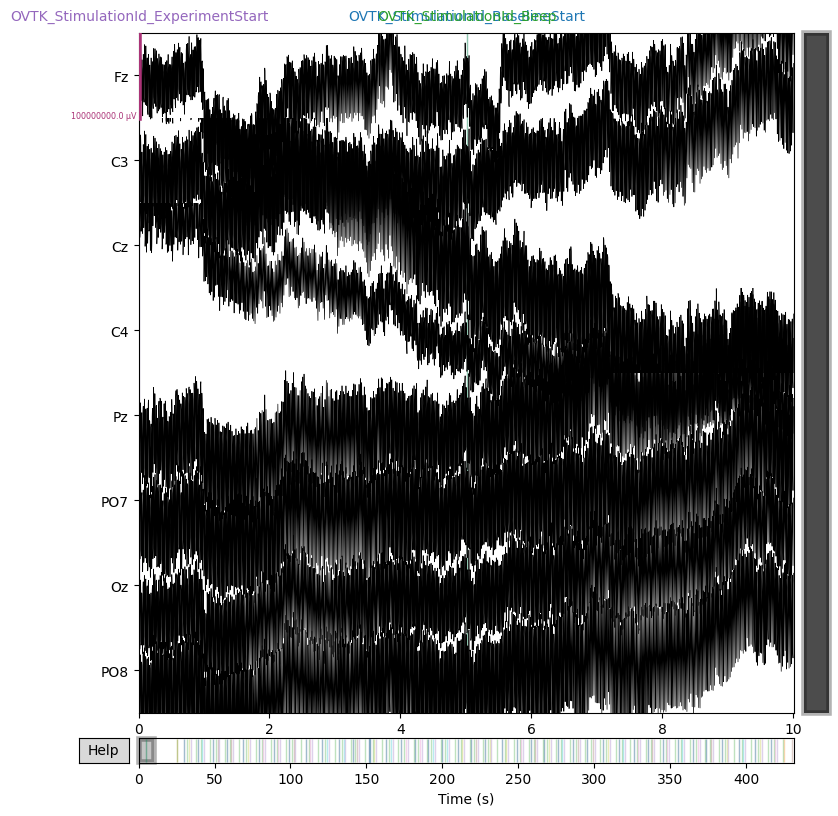

...


In [1851]:
raw_edf.plot(
    duration=10, 
    start=0.0, 
    scalings=50, # You may edit scalings value later
    )
print("...")

In [1852]:
max(raw_edf[6][0][0])

95823.09

# Feature Extraction

- MRCP , LF-ASD (try to add sapatial filter later)

In [1853]:
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from tsfilt import (
    BoxFilter, GaussianFilter, BilateralFilter, IdenticalFilter, NonLocalMeanFilter
)

In [1854]:
eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=3.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 1.00, 3.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


c:\Python311\Lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [1855]:
max(eeg1[0][0][0])

294.9128006203801

In [1856]:
eeg1= eeg1.pick_channels(['C3','Cz','C4'])
events, event_dict = mne.events_from_annotations(eeg1)
epochs = mne.Epochs(eeg1, events, 
        tmin=-1.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=3.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
205 matching events found
Setting baseline interval to [-1.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 205 events and 1126 original time points ...
2 bad epochs dropped


In [1857]:
def display(x, x_filt, title):
    plt.figure(figsize=(20, 3))
    plt.plot(x, "-", label="original")
    plt.plot(x_filt, "-", label="filtered")
    plt.title(title)
    plt.legend()
    plt.show()

WIN_SIZE = 1125
Select_channel = 3
filters = {
    # "box": BoxFilter(WIN_SIZE),
    "gaussian": GaussianFilter(WIN_SIZE, sigma_d=20),
    # "bilateral": BilateralFilter(WIN_SIZE, sigma_d=15, sigma_i=7.5),
    # "non local mean": NonLocalMeanFilter(WIN_SIZE)
}
# print(filters.items())
left_epochs = epochs['OVTK_GDF_Left']
right_epochs = epochs['OVTK_GDF_Right']
up_epochs = epochs['OVTK_GDF_Up']
for filter_name,filt in filters.items():
    for j in range(0,Select_channel):
        for i in range(0,len(epochs['OVTK_GDF_Left'])):
            left_filt = filt.fit_transform(left_epochs.get_data()[i][j])
            left_epochs._data[i][j] = left_filt
            right_filt = filt.fit_transform(right_epochs.get_data()[i][j])
            right_epochs._data[i][j] = right_filt
            up_filt = filt.fit_transform(up_epochs.get_data()[i][j])
            up_epochs._data[i][j] = up_filt

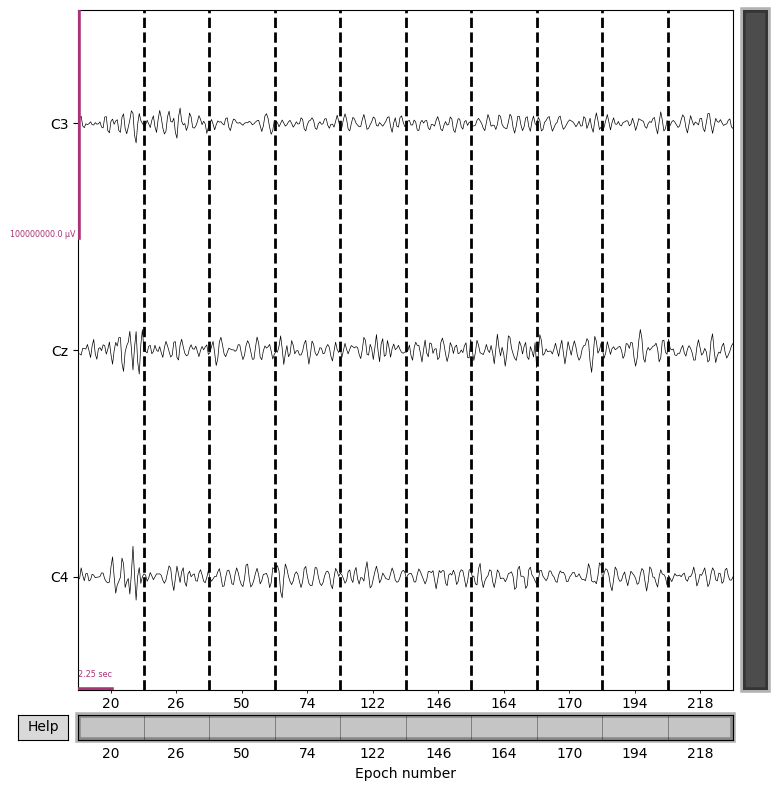

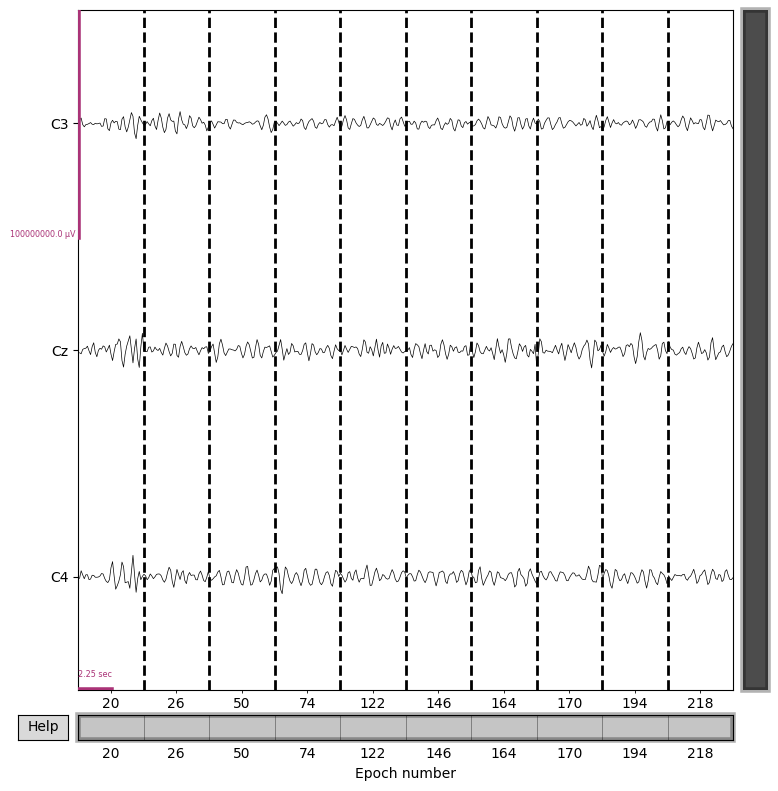

In [1858]:
epochs['OVTK_GDF_Left'].plot(
    scalings=50, # You may edit scalings value later
)
left_epochs.plot(
    scalings=50, # You may edit scalings value later
)
left = left_epochs['OVTK_GDF_Left'].average()

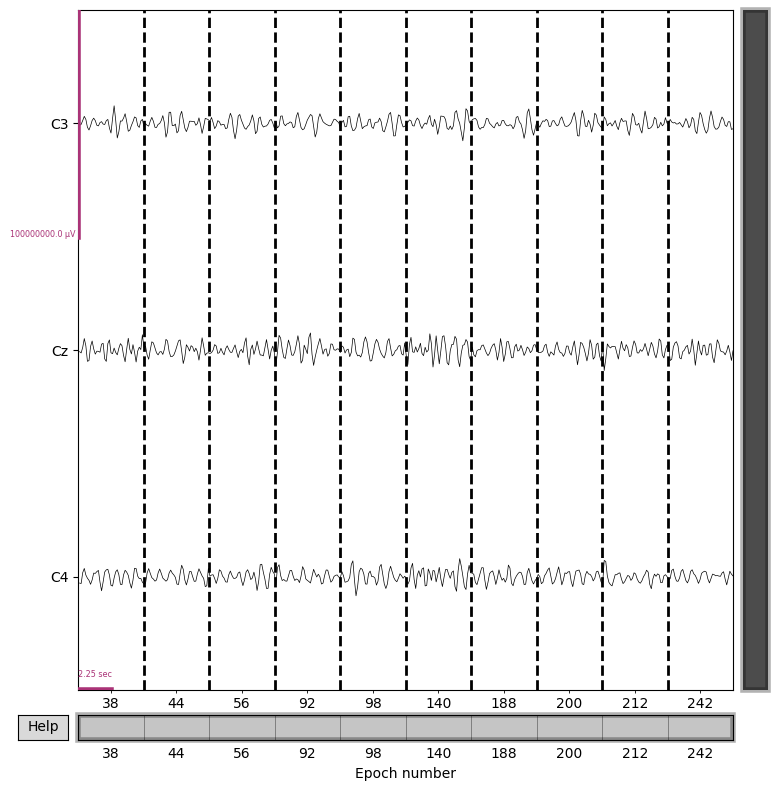

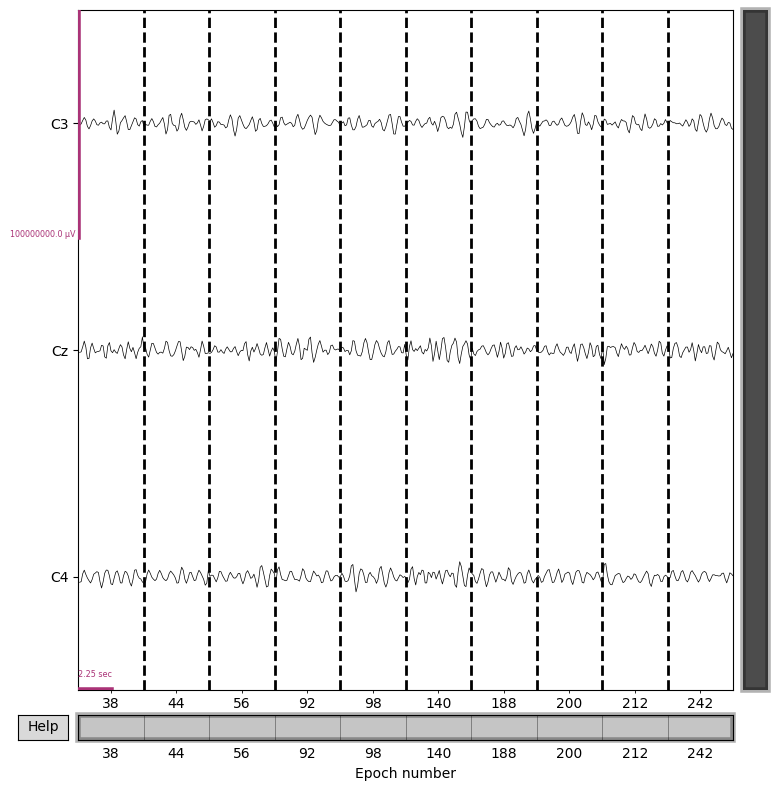

In [1859]:
epochs['OVTK_GDF_Right'].plot(
    scalings=50, # You may edit scalings value later
)
right_epochs.plot(
    scalings=50, # You may edit scalings value later
)
right = right_epochs['OVTK_GDF_Right'].average()

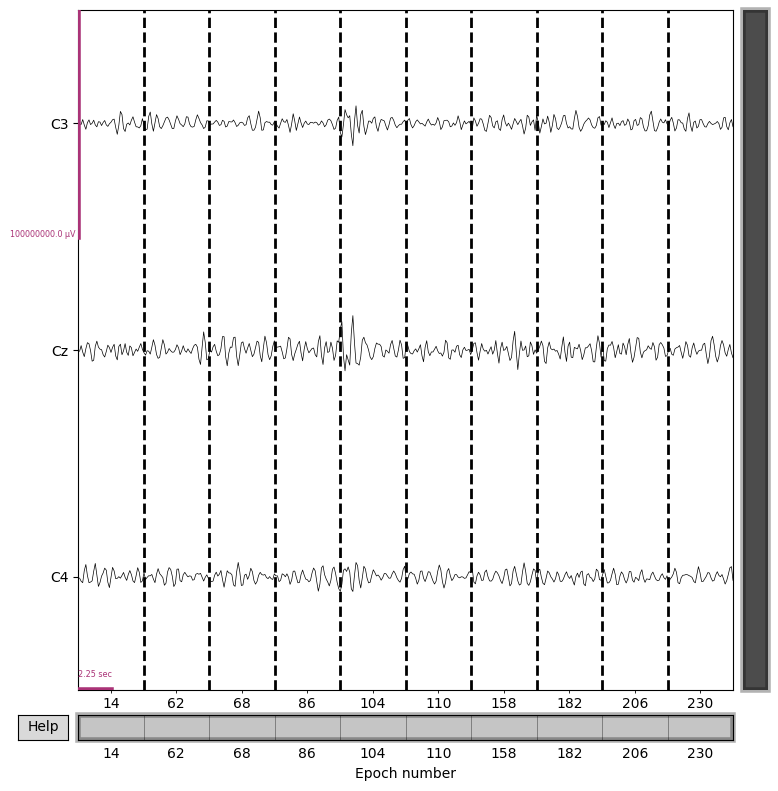

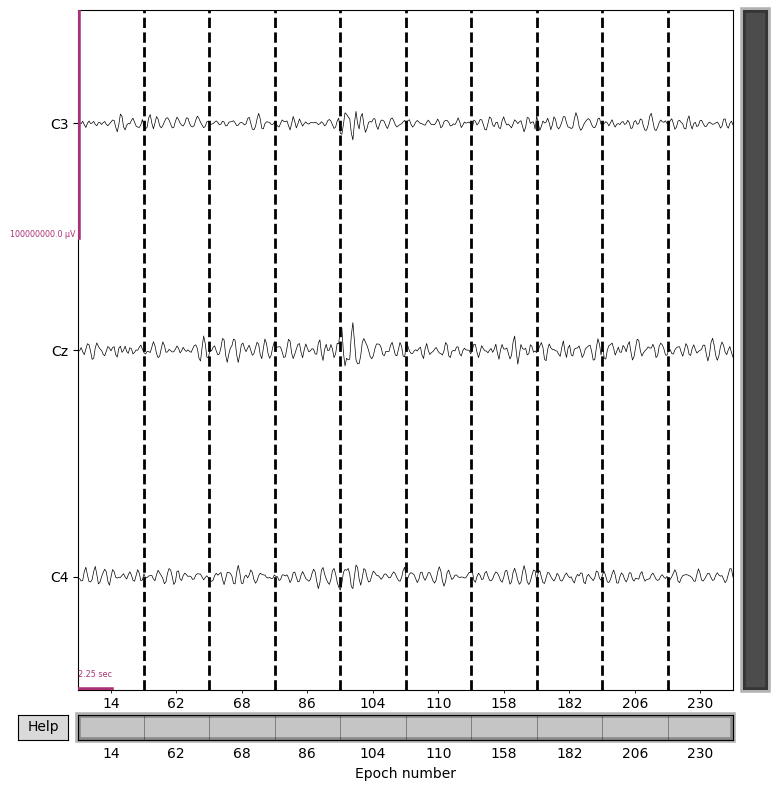

In [1860]:
epochs['OVTK_GDF_Up'].plot(
    scalings=50, # You may edit scalings value later
)
up_epochs.plot(
    scalings=50, # You may edit scalings value later
)
up = up_epochs['OVTK_GDF_Up'].average()

Need more than one channel to make topography for eeg. Disabling interactivity.


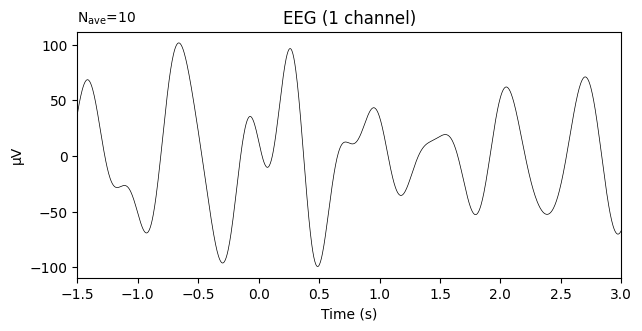

Need more than one channel to make topography for eeg. Disabling interactivity.


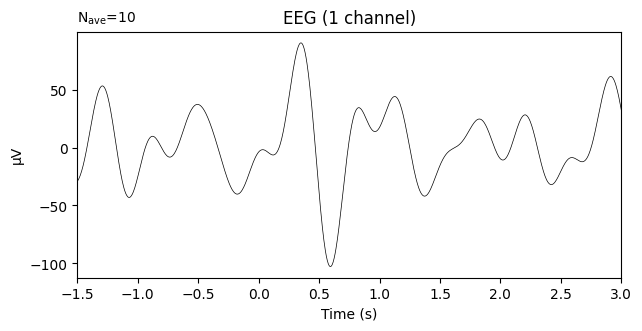

Need more than one channel to make topography for eeg. Disabling interactivity.


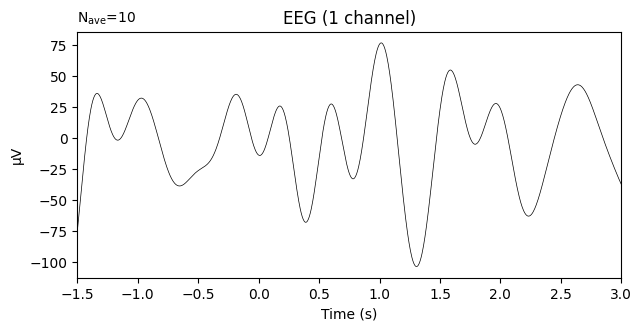

...


In [1861]:
up.plot(scalings=50, picks="Cz")
left.plot(scalings=50, picks="C4")
right.plot(scalings=50, picks="C3")
print("...")

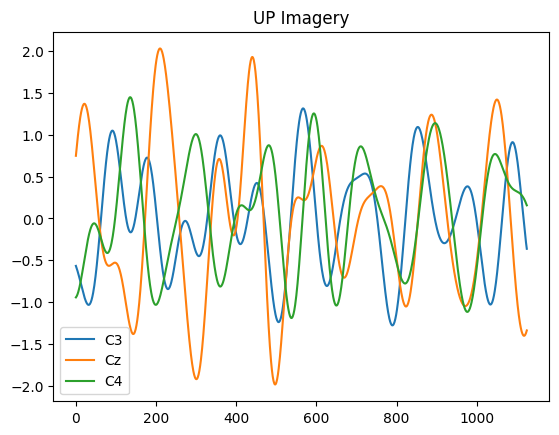

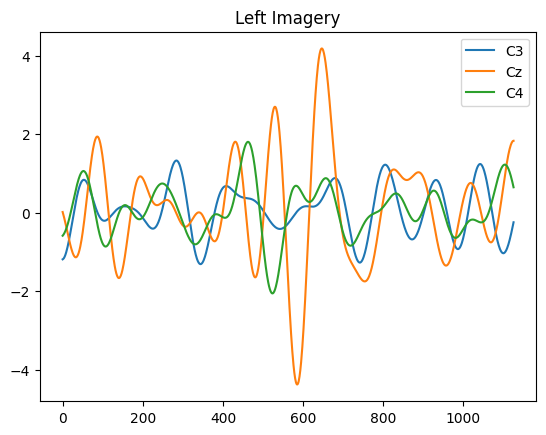

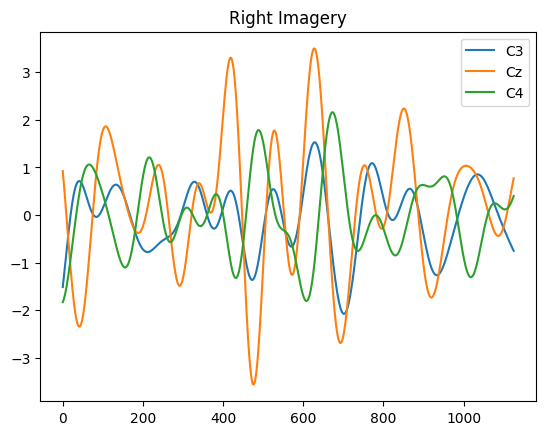

In [1862]:
plt.plot(up.get_data()[0],label='C3')
plt.plot(up.get_data()[1],label='Cz')
plt.plot(up.get_data()[2],label='C4')
plt.title('UP Imagery')
plt.legend()
plt.show()

plt.plot(left.get_data()[0],label='C3')
plt.plot(left.get_data()[1],label='Cz')
plt.plot(left.get_data()[2],label='C4')
plt.title('Left Imagery')
plt.legend()
plt.show()

plt.plot(right.get_data()[0],label='C3')
plt.plot(right.get_data()[1],label='Cz')
plt.plot(right.get_data()[2],label='C4')
plt.title('Right Imagery')
plt.legend()
plt.show()

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


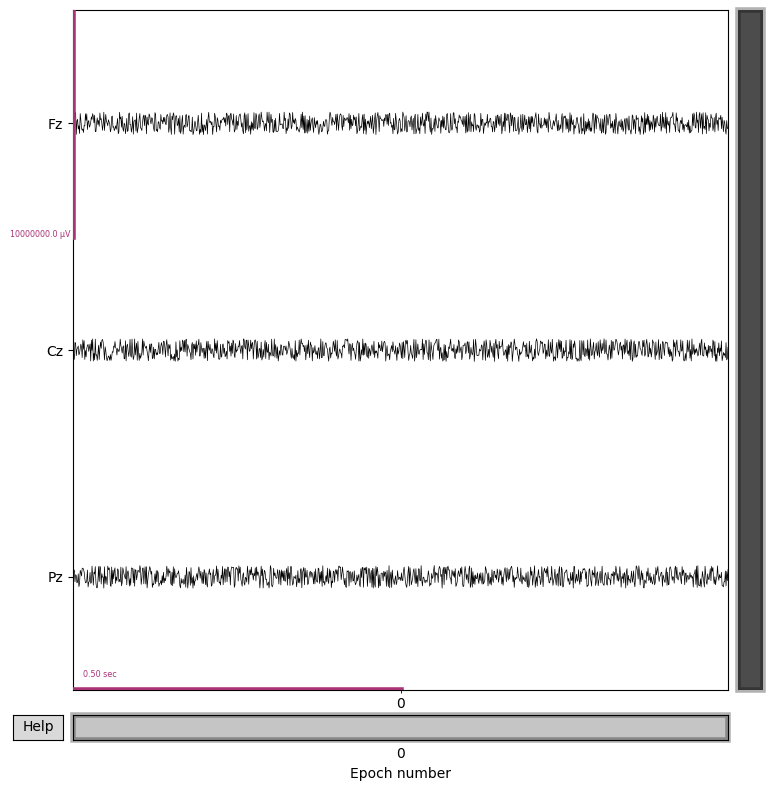

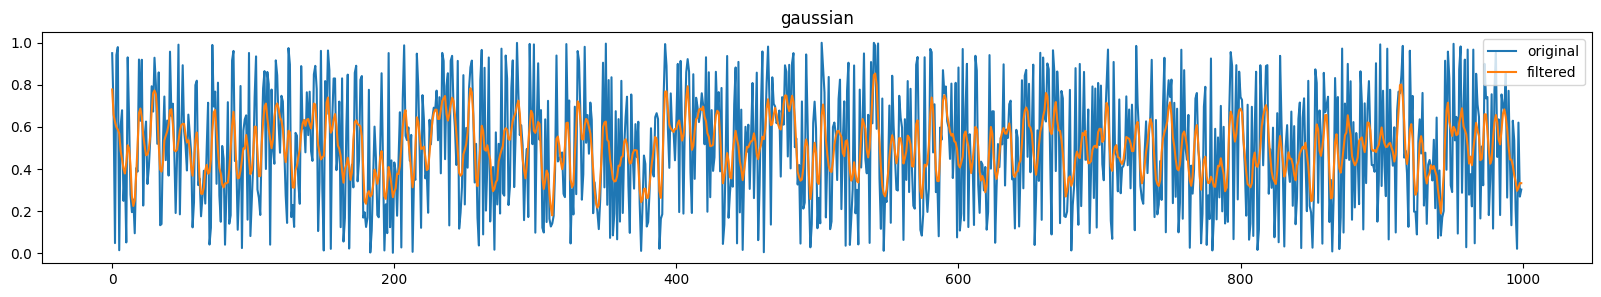

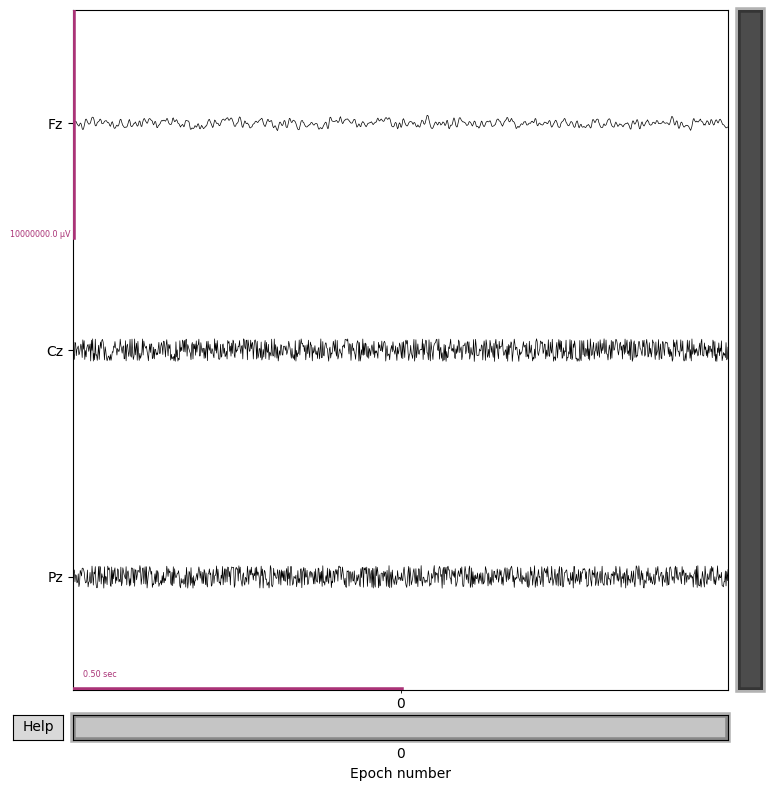

...


In [1863]:
import mne
import numpy as np


def display(x, x_filt, title):
    plt.figure(figsize=(20, 3))
    plt.plot(x, "-", label="original")
    plt.plot(x_filt, "-", label="filtered")
    plt.title(title)
    plt.legend()
    plt.show()
# Create example epochs
sfreq = 1000  # Sampling frequency (Hz)
ch_names = ['Fz', 'Cz', 'Pz']  # EEG channel names
n_channels = len(ch_names)
n_epochs = 10  # Number of epochs
n_samples = 1000  # Number of time points per epoch

# Create synthetic data
data = np.random.rand(n_epochs, n_channels, n_samples)

# Create an info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

WIN_SIZE = 5
filters = {
    # "box": BoxFilter(WIN_SIZE),
    "gaussian": GaussianFilter(WIN_SIZE, sigma_d=1.5),
    # "bilateral": BilateralFilter(WIN_SIZE, sigma_d=35, sigma_i=30),
    # "non local mean": NonLocalMeanFilter(WIN_SIZE)
}
# print(filters.items())

# Create Epochs object
epochs1 = mne.EpochsArray(data, info)
epochs1[0].plot(scalings=5)

for filter_name,filt in filters.items():
    x_filt = filt.fit_transform(epochs1.get_data()[0][0])
    display(epochs1.get_data()[0][0], x_filt, filter_name)

# Modify the data of the first epoch (for example, set it to zeros)
new_data = x_filt
epochs1._data[0][0] = new_data  # Modify the data for the first epoch

# Print the modified data of the first epoch
epochs1[0].plot(scalings=5)
print("...")

- ERD/ERS

- PSD

- CSP

- CWT

- STFT